In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_curve,auc,accuracy_score

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('../data/haberman_csv.csv')

In [3]:
df.columns

Index(['Age_of_patient_at_time_of_operation', 'Patients_year_of_operation',
       'Number_of_positive_axillary_nodes_detected', 'Survival_status'],
      dtype='object')

In [4]:
df=df.drop(columns=['Patients_year_of_operation'])

In [5]:
df.shape

(306, 3)

In [6]:
df=df.rename(columns={'Age_of_patient_at_time_of_operation':'age', 'Number_of_positive_axillary_nodes_detected':'detections'})

In [7]:
data=df.values
X=data[:,:2]
Y=data[:,2]

In [8]:
X_train,x_test,Y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=9)

In [9]:
tree=DecisionTreeClassifier(random_state=9)

tree_params={'max_depth':[3,4,5,6],'max_features':[1,2]}

tree_grid=GridSearchCV(tree,tree_params,scoring='accuracy',n_jobs=-1,cv=10,verbose=2)

tree_grid.fit(X_train,Y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=9,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6], 'max_features': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_

In [10]:
import pydotplus
from sklearn.tree import export_graphviz

def draw_tree(tree,features,location):
    tree_string=export_graphviz(tree,feature_names=features,filled=True,out_file=None)
    graph=pydotplus.graph_from_dot_data(tree_string)
    graph.write_png(location)

In [11]:
tree_grid.best_score_

0.7383177570093458

In [12]:
accuracy_score(y_test,tree_grid.predict(x_test))

0.6847826086956522

In [13]:
draw_tree(tree_grid.best_estimator_,['age', 'detections'],\
          location='../imgs/tree_grid1.png')

<img src='../imgs/tree_grid1.png'>

In the above Decision Tree representation that is generated, blue colored leaves are for minority class(it could change on other representations).

values parameter represents number of samples of both classes.
Value=[0,4] meaning 0 sample from 1st class and 4 samples from 2nd class.

Blue colored leaves only contains samples from minority class. So, if we can extract rules that made these pure minority class regions in decision tree which i beleieve represents decsion bounderies in N-dimensional space also, then we have samples that are relatively represent pure regions as there are no samples from other class

Accuracy of DecisionTreeClassifier should not be an issue, because we are not taking all rules gererate in the tree, we are only taking leaves that is purely one class and does not have any ambiguities with other class samples.


<img src='../imgs/tree_grid1 - paths.png'>

In the above pictures red circled leaves contains samples from minority class only. So, if we extract rules following the green line and replicate samples within those rules, I believe it will fall in the same pure regions.

In [14]:
from sklearn import tree

Extracting rules from the tree

In [15]:
import SampleExtraction # code in SampleExtraction.py in same folder

In [19]:
best_tree=tree_grid.best_estimstor

Finding samples that fall within rules that leads to samples of only minority class (pure regions)

In [20]:
pure_samples_X_train,pure_samples_with_class,rules_with_pure_class=SampleExtraction.pure_sample_extraction(best_tree,X_train,Y_train,2)

In [21]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [22]:
pure_X_train=np.array(pure_samples_X_train)

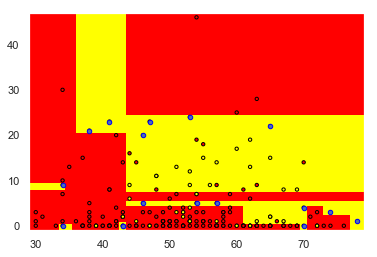

In [23]:
xx,yy=get_grid(X_train)

predicted1=best_tree.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)

plt.pcolormesh(xx,yy,predicted1,cmap='autumn')
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,s=11,cmap='autumn',edgecolors='black')
plt.scatter(pure_X_train[:,0],pure_X_train[:,1],s=20,cmap='spring',edgecolors='blue')
plt.legend()

In the above picture, blue dots represents samples of pure minority class that followed the rules colored green in the Decision Tree.

Yellow dots also represents minority class and Red dots represents majority class.
It is clear from the picture that rules in decision tree that generates leaves containing pure minority samples also make regions that are pure and contains no majority samples thus providing pure regions of minority class(representing rules that leads to leaves containing only minority class samples).

It roughly provides samples of minority class where oversampling will be safe. Decision rules that provide these pure regions can be used for oversampling.

In [24]:
#custom functions

import DecisionRules
import TreePathDictionary
import SampleGeneration

In [25]:
dic=DecisionRules.Tree_path(best_tree,pure_X_train)#passing best tree estimate and pure samples

In [26]:
min_max_dic,gen_dic=TreePathDictionary.sample_generation_dictionary(dic,X_train)

In [27]:
gen_dic

[{0: [30, 34.5], 1: [8.0, 9.5]},
 {0: [73.0, 77.0], 1: [2.5, 4.5]},
 {0: [43.5, 78], 1: [19.5, 24.5]},
 {0: [43.5, 78], 1: [4.5, 5.5]},
 {0: [33.5, 35.5], 1: [0, 0.5]},
 {0: [69.5, 70.5], 1: [0, 4.5]},
 {0: [36.0, 43.5], 1: [20.5, 46]},
 {0: [42.5, 43.5], 1: [0, 1.0]},
 {0: [77.0, 78], 1: [0, 4.5]}]

In [45]:
generated_samples=SampleGeneration.gen_samples(gen_dic,min_max_dic,X_train,15)#newly generated samples

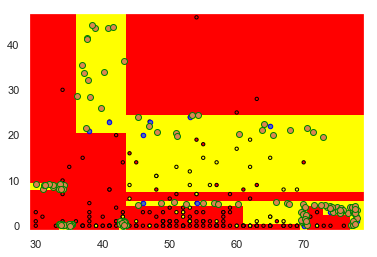

In [46]:
xx,yy=get_grid(X_train)

predicted1=best_tree.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)

plt.pcolormesh(xx,yy,predicted1,cmap='autumn')
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,s=11,cmap='autumn',edgecolors='black')
plt.scatter(pure_X_train[:,0],pure_X_train[:,1],s=20,cmap='spring',edgecolors='blue')
plt.scatter(generated_samples[:,0],generated_samples[:,1],cmap='spring',edgecolors='green')
plt.legend()

Here , yellow region in minority class region
Red is majority class region

Yellow dots with black edges represents original minority class sample.
Red dots woth black edges represents original majority class sample.

Blue dots pure sample of minority class.

Yellow dots with green edges represents generated samples.

In [40]:
y=[]
for i in range(0,len(generated_samples),1):
    y.append(2)
    
y=np.array(y)
y=y.reshape((y.shape[0],1))

genereated_samples=np.concatenate((generated_samples,y),axis=1)

In [41]:
generated_samples=pd.DataFrame(generated_samples)

In [42]:
generated_samples.to_csv('pure_region_sample.csv',index=False)